# 0- importation des bibliothèque

In [2]:
!pip install ruptures
!pip install loadmydata
!pip install sporco

In [3]:
# Load this to check if all packages are installed
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
from scipy import stats
from statsmodels.tsa.ar_model import AutoReg
from sporco.admm import bpdn
from statsmodels.regression.linear_model import yule_walker
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
import time
import ruptures as rpt
from loadmydata.load_uea_ucr import load_uea_ucr_data

# 1- Constante

In [5]:
#variable globale

Fe = 50

# 2- Téléchargement des données brutes intéressantes

Nous devons commencer par déterminer les signaux intéressants pour réaliser cette optimisation. Les données d'accélérométrie semble plus pertinente que celle de gyrométrie. De plus, nous pouvons supposer que le signal étant le plus suceptible à varier lors du mouvement est l'accélération selon z car des accoues se produisent à chauqe pas. C'est accoues sont surement différent selon de si on marche, monte ou descend les escaliers.
Nous allons donc commencer par étudier le signal d'accélérométrie selon z.

(7351, 128)


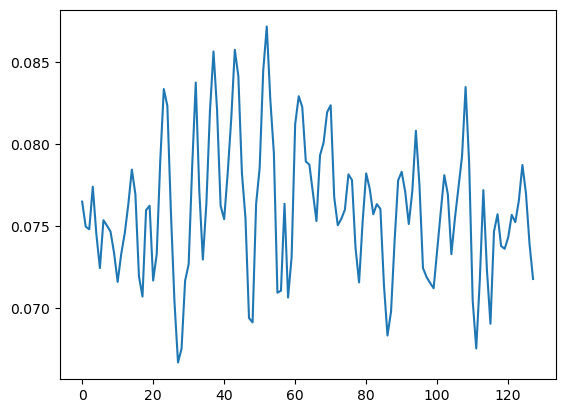

In [4]:
import numpy as np
import matplotlib.pyplot as plt
with open('total_acc_z_train.txt', 'r') as file:
    content = file.readlines()
Datas = []
# Display the first 10 lines to understand the structure
for line in content[:-1]:  # Adjust the number of lines as needed
    first_line = line.strip()  # Enlève les espaces et les sauts de ligne
    values = [float(x) for x in first_line.split()]  # Convertit chaque valeur en float
    values_array = np.array(values)  # Convertir en tableau NumPy
    Datas.append(values_array)
    """plt.clf()
    plt.plot(values_array)
    plt.show()"""
    #print("\nTableau NumPy :")
    #print(values_array)
    #print(values)
Datas = np.array(Datas)
print (np.shape(Datas))

#exemple de data :
plt.clf()
plt.plot(Datas[11])
plt.show()

Nous allons commencer dans cette partie par sélectionner uniquement les signaux où la personne est mobiles grâce au fichier Y_train.txt qui associe à chaque signal un état (marcher, assis, monter les escaliers...). Nous n'allons évidemment pas utiliser par la suite ce fichier pour déterminer les features permettant de classifier les fichiers.

Nous cherchons dans un premier temps à isoler les données d'accélérométrie selon z où la personne monte les escalier ou bien marche

In [5]:
# Ouverture et lecture de Y_train

with open('y_train.txt', 'r') as file:
    content = file.readlines()
DatasY = []
# Display the first 10 lines to understand the structure
for line in content[:-1]:  # Adjust the number of lines as needed
    first_line = line.strip()  # Enlève les espaces et les sauts de ligne
    values = [float(x) for x in first_line.split()]  # Convertit chaque valeur en float
    values_array = np.array(values)  # Convertir en tableau NumPy
    DatasY.append(values_array)

DatasY = np.array(DatasY)

# Sélectionner les signaux où DatasY est dans [1, 2] c'est à dire les signaux où la personne marche ou bien monte les escalier
indices_mobiles = np.isin(DatasY, [1, 2]).flatten() # Flatten the boolean array to match the dimension of Datas
Datas_mobiles = Datas[indices_mobiles]

print (DatasY[100])
print (indices_mobiles[100])
#print (Datas_mobiles[1])
print("structure de notre dataset d'étude :", Datas_mobiles.shape)
print("structure du dataset de base :", Datas.shape)

[1.]
True
structure de notre dataset d'étude : (2298, 128)
structure du dataset de base : (7351, 128)


# 3-Prétraitement des données

Nous avons à présent isoler les données mobiles de notre dataset. Nous pouvons à présent structurer nos données en créant une class signal

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from scipy.signal import find_peaks, butter, filtfilt
Fe = 50
class Signal:
    def __init__(self, data):
        """
        Initialise un objet Signal.

        :param data: Les données du signal (tableau numpy ou liste).
        :param sampling_rate: Fréquence d'échantillonnage (en Hz).
        """
        self.data = np.array(data)
        self.Fsampling = Fe
        self.sampling_rate = 1/Fe
        self.duration = 2.56
        self.time = np.linspace(0, self.duration, len(data))  # Axe temporel

    def plot(self, title="Signal", data = True , data_filtered = False, data_trend = False, data_filtered_detrend = False ):
        """
        Affiche le signal dans le domaine temporel.
        """
        plt.figure(figsize=(10, 4))
        if data :
          plt.plot(self.time, self.data, label = "signal d'origine")
        if data_filtered :
          plt.plot(self.time, self.filtered_data, label = "signal filtered")
        if data_trend :
          plt.plot(self.time, self.trend, label = "signal trend")
        if data_filtered_detrend :
          plt.plot(self.time, self.detrend_filtered_data, label ="signal filtered without trend")
        plt.title(title)
        plt.legend()
        plt.xlabel('Temps (s)')
        plt.ylabel('Amplitude')
        plt.grid(True)
        plt.show()

    def apply_fft(self, data = True , data_filtered = False, data_trend = False, data_filtered_detrend = False ):
        """
        Applique la transformation de Fourier rapide (FFT) au signal.

        :return: Tuple (fréquence, magnitude)
        """
        if data:
          N = len(self.data)
          T = 1/self.Fsampling
          yf = fft(self.data)
          xf = np.fft.fftfreq(N, T)[:N//2]
          magnitude = 2.0/N * np.abs(yf[:N//2])
          self.xf = xf
          self.magnitude = magnitude
        if data_filtered:
          N = len(self.filtered_data)
          T = 1/self.Fsampling
          yf = fft(self.filtered_data)
          xf = np.fft.fftfreq(N, T)[:N//2]
          magnitude = 2.0/N * np.abs(yf[:N//2])
          self.xf_filtered = xf
          self.magnitude_filtered = magnitude
        if data_trend:
          N = len(self.trend)
          T = 1/self.Fsampling
          yf = fft(self.trend)
          xf = np.fft.fftfreq(N, T)[:N//2]
          magnitude = 2.0/N * np.abs(yf[:N//2])
          self.xf_trend = xf
          self.magnitude_trend = magnitude
        if data_filtered_detrend:
          N = len(self.detrend_filtered_data)
          T = 1/self.Fsampling
          yf = fft(self.detrend_filtered_data)
          xf = np.fft.fftfreq(N, T)[:N//2]
          magnitude = 2.0/N * np.abs(yf[:N//2])
          self.xf_filtered_detrend = xf
          self.magnitude_filtered_detrend = magnitude
        return xf, magnitude

    def plot_fft(self, data = True , data_filtered = False, data_trend = False, data_filtered_detrend = False ):
        """
        Affiche le spectre en fréquence du signal.
        """
        plt.figure(figsize=(10, 4))
        if data:
          plt.plot(self.xf, self.magnitude, label = "Signal d'origine")
        if data_filtered:
          plt.plot(self.xf_filtered, self.magnitude_filtered, label ="Signal Filtered")
        if data_trend:
          plt.plot(self.xf_trend, self.magnitude_trend, label ="Signal Trend")
        if data_filtered_detrend:
          plt.plot(self.xf_filtered_detrend, self.magnitude_filtered_detrend, label ="Signal Detrended")

        plt.title("Spectre en fréquence")
        plt.legend()
        plt.xlabel('Fréquence (Hz)')
        plt.ylabel('Magnitude')
        plt.grid(True)
        plt.show()


    def filter_signal(self, cutoff, order=5, filter_type='low'):
        """
        Filtre le signal à l'aide d'un filtre passe-bas, passe-haut, ou passe-bande.

        :param cutoff: Fréquence de coupure (Hz).
        :param order: Ordre du filtre (plus élevé signifie un filtre plus "sharp").
        :param filter_type: Type de filtre ('low', 'high', 'band').
        :return: Le signal filtré.
        """
        nyquist = 0.5 * self.sampling_rate
        if filter_type == 'low':
            normal_cutoff = cutoff * nyquist
            b, a = butter(order, normal_cutoff, btype='low', analog=False)
        elif filter_type == 'high':
            normal_cutoff = cutoff * nyquist
            b, a = butter(order, normal_cutoff, btype='high', analog=False)
        elif filter_type == 'band':
            low, high = cutoff
            normal_cutoff = [low * nyquist, high * nyquist]
            b, a = butter(order, normal_cutoff, btype='band')
        else:
            raise ValueError("Type de filtre non supporté. Choisissez 'low', 'high' ou 'band'.")

        self.filtered_data = filtfilt(b, a, self.data)
        return self.filtered_data

    def trending(self):
        # Regression on polynomial functions
        N = len(self.data)
        t = np.linspace(0, self.duration, N)
        D=np.zeros((N,3))
        D[:,0]=np.ones(N)
        D[:,1]=t
        D[:,2]=np.power(t,2)


        alpha=np.dot(np.linalg.inv(np.dot(np.transpose(D),D)),np.dot(np.transpose(D),self.filtered_data)) #Regression parameters
        self.trend =np.dot(D,alpha); #Reconstruction
        self.detrend_filtered_data = self.filtered_data - self.trend; #Detrended signal
        return self.detrend_filtered_data


# Conversion de tout le dataset en class
Datas_class = []
for signal in Datas_mobiles:
  s = Signal(signal)
  Datas_class.append(s)

Nous commençons par filtrer le bruit haute fréquence des données. D'après la biblio la fréquence de pas lorsque l'on marche ou bien monte des escalier est inférieur à 4 Hz. Donc nous pouvons filtrer toutes les fréquence au dessus de cela en appliquant un filtre passe bas. De plus nous sommes sensé avoir des signaux centré.

In [7]:
#Filtrage des signaux du dataset
for signal in Datas_class:
  signal.filter_signal(cutoff=15, order=5, filter_type='low')
  signal.trending()
  signal.apply_fft(data_filtered = True, data_trend = True, data_filtered_detrend = True)

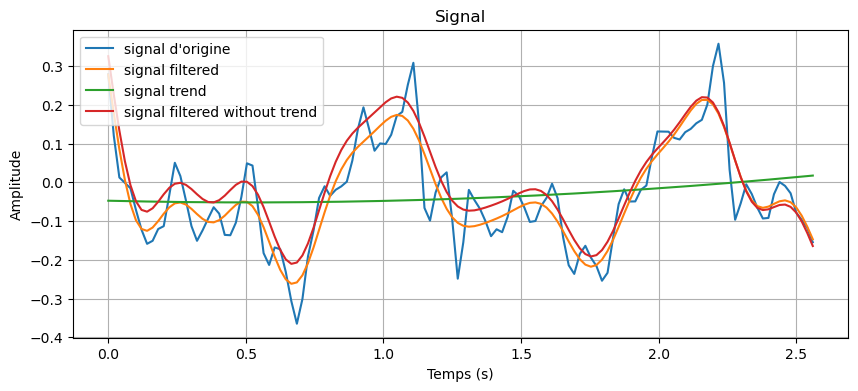

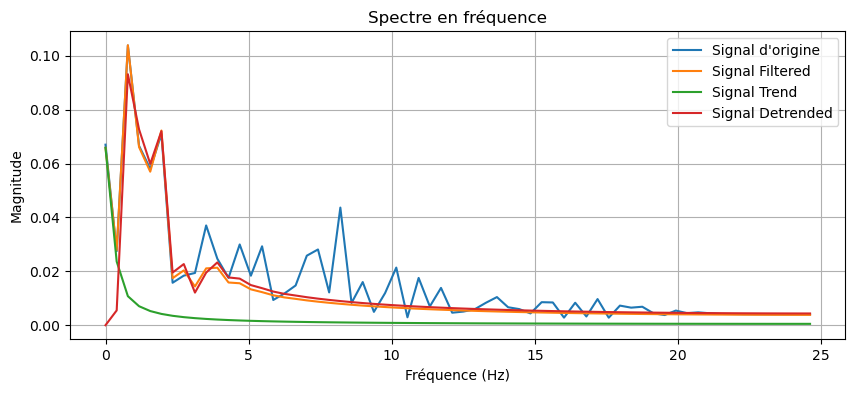

In [8]:
Datas_class[1].plot(data_filtered = True, data_trend = True, data_filtered_detrend = True)
Datas_class[1].plot_fft(data_filtered = True, data_trend = True, data_filtered_detrend = True)

# 4-Traitement des données

### 4.1- Apprentissage de dictionnaire (fail)

Nous avons réalisé un apprentissage de dictionnaire basée sur un l'algorithme présenté dans le cours 3 [Dictionnary learning](https://www.laurentoudre.fr/ast.html) de Laurent Oudre.

In [10]:
class AnalyseDataset :
  def __init__(self, data):
    self.data = data
    self.xplot = np.linspace(0, 100, len(self.data), endpoint=False)  # De 0 à T (sans inclure T)
    self.data_array = np.array([signal.detrend_filtered_data for signal in self.data])
    self.data_array_transposed = self.data_array.T
  def meandata(self):
    """
    Calcule la moyenne des données.

    :return: Moyenne des données.
    """
    Lmean = []
    for signal in self.data:
      Lmean.append(np.mean(signal.data))
    self.Lmean = np.array(Lmean)
    return self.Lmean

  def stddata(self):
    """
    Calcule l'écart
    """
    Lstd = []
    for signal in self.data:
      Lstd.append(np.std(signal.data))
    self.Lstd = np.array(Lstd)
    return self.Lstd

  def peakdata(self):
    """
    Calcule le nombre de pics dans le signal.
    """
    Lpeak = []
    for signal in self.data:
      Lpeak.append(len(signal.detect_peaks()))
    self.Lpeak = np.array(Lpeak)
    return self.Lpeak

  def plot_analyse(self , meandata = True , stddata = False, peakdata = False):
    """
    Affiche le signal avec les pics détectés.
    """
    plt.figure(figsize=(10, 4))
    if meandata:
      self.Lmean.sort()
      plt.scatter(self.xplot, self.Lmean, label="Moyenne")
    if stddata:
      self.Lstd.sort()
      plt.scatter(self.xplot, self.Lstd, label="Ecart type")
    if peakdata:
      self.Lpeak.sort()
      plt.scatter(self.xplot, self.Lpeak, label="Nombre de pics")

    plt.xlabel('signaux')
    plt.ylabel('values des features')
    plt.legend()

    # Partie analyse des données Filtrées

  def mean_detrend_filtered(self):
    """
    Calcule la moyenne des données.

    :return: Moyenne des données.
    """
    Lmean = []
    for signal in self.data:
      Lmean.append(np.mean(signal.detrend_filtered_data))
    self.Lmean_detrend_filtered = np.array(Lmean)
    return self.Lmean_detrend_filtered

  def std_detrend_filtered(self):
    """
    Calcule l'écart
    """
    Lstd = []
    for signal in self.data:
      Lstd.append(np.std(signal.detrend_filtered_data))
    self.Lstd_detrend_filtered = np.array(Lstd)
    return self.Lstd_detrend_filtered

  def peak_detrend_filtered(self):
    """
    Calcule le nombre de pics dans le signal.
    """
    Lpeak = []
    for signal in self.data:
      Lpeak.append(len(signal.detect_peaks(height=0.5, distance=10)))
    self.Lpeak_detrend_filtered = np.array(Lpeak)
    return self.Lpeak_detrend_filtered


  def create_dictionnary(self) :# on veut créer nos atomes et nos dictionnaires pour essayer de classifier les données
    """
    On veut créer dans cette fonction les atomes et les fonctions d'activation qui vont permettre de reconstruire les données.
    """
    def sparse_coding_matrix(X ,D,K0):
      niter = 100
      gamma = 1/(np.linalg.norm(D,2)**2)
      Nw,Nd=np.shape(X)
      Nw,K=np.shape(D)
      print(Nw, Nd, K)
      Z=np.zeros((K,Nd))
      for i in range(niter):
          r= np.dot(D,Z)-X
          C=Z - gamma * np.dot(np.transpose(D),r)
          for j in range(Nd):
              c=C[:,j]
              ind=np.argsort(np.abs(c))
              c[ind[np.arange(0,K-K0)]]=0
              Z[:,j]=c
      error = np.linalg.norm(X-np.dot(D,Z))**2
      print("error=",error)
      return Z, error
    def dictionary_learning_matrix(X ,Z,D):
      niter = 100
      gamma = 1/(np.linalg.norm(Z,2)**2)
      Nw,Nd=np.shape(X)
      Nw,K=np.shape(D)
      for i in range(niter):
          r=np.dot(D,Z)-X
          D=D - gamma * np.dot(r,np.transpose(Z))
          for j in range(K):
              D[:,j]=D[:,j]/np.sqrt(np.sum(D[:,j]**2))
      return D
    def plot_atoms(K,D) :
      # Plot of the initialized dictionary
      plt.figure("Plot of the initialized random dictionary")
      for i in range(K):
        plt.subplot(K,1,i+1)
        plt.plot(D[:,i])
      plt.show()

    def plot_learning(Z, D, MSE) :
      # Plot the learned atoms and activations
      Z_max=np.max(Z)
      Z_min=np.min(Z)
      D_max=np.max(D)
      D_min=np.min(D)
      plt.figure("Learned atoms and activations")
      for k in range(K):
        plt.subplot(K,4,4*k+1)
        plt.plot(D[:,k])
        plt.xlim((0, Nw))
        plt.ylim((D_min, D_max))
        plt.ylabel("Atome "+str(k))
        plt.subplot(K,4,(4*k+2,4*k+4))
        if k==0 :
          plt.title("Activations correspondantes aux atomes ")
        plt.bar(np.arange(Nd),Z[k,:])
        plt.ylim((Z_min,Z_max))
      plt.legend()
      plt.show()

      plt.clf()
      plt.figure("MSE")
      plt.title("Evolution de la MSE au cours des itérations")
      plt.xlabel("Iterations")
      plt.ylabel("MSE")
      plt.plot(MSE, label = 'MSE')
      plt.legend()
      plt.show()

    def test_reconstruction(X, D, Z, ntest = 3) :# Try to buil back the signal, with just 2 atoms.
      signals_build = np.zeros((ntest, Nw))
      for i in range(ntest):
        signals_build[i,:] = np.dot(D,Z[:,i])

      plt.figure("Reconstruction", figsize = (10, 8))
      for i in range(ntest):
        plt.subplot(ntest,1,i+1)
        plt.plot(signals_build[i,:], label = 'reconstruction'+str(Z[:,i]))
        plt.plot(X[:,i], label = 'original'+str(i))
        plt.ylim((-0.3, 0.6))
        plt.legend()
      plt.show()

    # Création d'un dictionnaire aléatoire avec 2 atomes (car 2 classes)
    K = 2 # Number of atoms
    Nw = len(self.data[0].data)# tailles des atomes
    Nd = self.data_array.shape[0]
    print(Nw,Nd)
    D=np.random.randn(Nw,K)
    for k in range(K):# on normalise chaque atome
      D[:,k]=(D[:,k]-np.mean(D[:,k]))
      D[:,k]=D[:,k]/np.sqrt(np.sum(D[:,k]**2))

    plot_atoms(K, D)# On affiche les atomes initialisé

    # Perform the alternate minimization (sparse coding + dictionary learning)
    Lerror = []
    progression = 100
    while progression > 2 :
      Z, error =sparse_coding_matrix(self.data_array_transposed,D,K)
      D=dictionary_learning_matrix(self.data_array_transposed,Z,D)
      plot_atoms(K, D)
      Lerror.append(error)
      if len(Lerror) > 1 :
        progression = Lerror[-2]- Lerror[-1]
    plot_learning(Z, D, Lerror)
    test_reconstruction(self.data_array_transposed, D, Z, ntest = 3)
    self.Z = Z
    self.D = D
    return D, Z






AnalyseData_class = AnalyseDataset(Datas_class)
#D, Z = AnalyseData_class.create_dictionnary()

Nous pouvons observer que l'erreur reste très importante à la fin de l'apprentissage. Cela vient du fait que la reconstruction d'un signal à partir de seulement 2 atomes est sensible au déphasage du signal.

### 4.2-Détection des principaux motifs du dataset.

Comme expliquer dans le cours 1 [Patern detection](https://www.laurentoudre.fr/ast.html)de Laurent Oudre et dans le rapport du projet, nous avons coder l'algorithme de détection de motif basée sur un calcul de matrix profile. Cependant ce dernier prend 20h à trouner car la compléxité est en $O(N^3log(N))$. Nous avons donc réfléchis à une version optimisée de l'algorithme.

#### 4.2.1 Detection de motifs (Fail)

In [11]:
from tqdm import tqdm
cla"ss AnalyseDatasetPatern2D(AnalyseDataset) :
  def __init__(self, data):
    super().__init__(data) # on a la même initialisation que la class AnalysDataset et les même fonction
    deb = 0
    nbtrams= -1
    self.data_array = self.data_array[deb:deb+nbtrams, :]



  def detect_paterns(self, seuil):
    # Optimized implementation of sliding Euclidean distance with Mueen's algorithm
    def fast_distance_profile_nEUC(x,p):
      c=np.cumsum(np.concatenate(([0],x)))
      c2=np.cumsum(np.concatenate(([0],x))**2)
      N=np.size(x)
      Np=np.size(p)
      p_=(p-np.mean(p))/np.std(p)
      p__=np.zeros((N,))
      p__[0:Np]=np.flip(p_)
      r=np.real(np.fft.ifft(np.multiply(np.fft.fft(x),np.fft.fft(p__))))
      vari=np.sqrt(Np * (c2[Np:-1]-c2[:N-Np]) -  (c[Np:-1]-c[:N-Np])**2)
      d=np.sqrt(np.maximum(2*Np*(1-np.divide(r[Np-1:N-1],vari)),0))
      return d

    def matrix_profile_upgrade(x,w, seuil):#l'objectif est d'aussi comptabiliser le nombre de fois qu'un patern se répète

      def detect_pic_2D(deuclide, seuil, L=70):
        """
        Fonction pour détecter les motifs (patterns) dans un tableau 2D (deuclide).
        Chaque ligne de deuclide est traitée individuellement.

        Parameters:
        - deuclide: Tableau 2D où chaque ligne représente une trame du signal.
        - seuil: Seuil pour la détection des motifs.
        - L: Longueur du motif à détecter.

        Returns:
        - Lmin_local_2D: Liste des indices des minimums détectés pour chaque ligne (trame).
        """
        n_lignes, n_colonnes = deuclide.shape  # Dimensions du tableau 2D
        Lmin_local_2D = []
        deuclide_seuil = [[deuclide_value if deuclide_value <= seuil else None for deuclide_value in ligne] for ligne in deuclide]  # Contient par défault des None
        # Boucle sur chaque trame (chaque ligne du tableau)
        for ligne in range(n_lignes):
            INDEX_TOTAL = 0
            while INDEX_TOTAL < n_colonnes:
                # Use nested indexing to access elements in the list of lists
                if deuclide_seuil[ligne][INDEX_TOTAL] is not None:  # Changed this line
                    START = INDEX_TOTAL
                    while INDEX_TOTAL < n_colonnes and deuclide_seuil[ligne][INDEX_TOTAL] is not None:  # Changed this line
                        INDEX_TOTAL += 1
                    END = INDEX_TOTAL
                    # Use nested indexing to access elements in the list of lists
                    Lmin_local_2D.append((ligne, deuclide_seuil[ligne][START:END].index(min(deuclide_seuil[ligne][START:END])) + START))  # Changed this line
                INDEX_TOTAL += 1
        return Lmin_local_2D


      seuil = seuil
      nblines, N=np.shape(x)
      c=np.zeros((nblines,N-w))
      d=np.Inf*np.ones((nblines, N-w))
      for j in tqdm(range(nblines)):
        xselect = x[j,:]
        for i in range(N-w):
          xintervalle=xselect[i:i+w]
          Lmin_local_global = []
          for k in range (nblines):
            if k != j :
              c[k, :]=fast_distance_profile_nEUC(x[k, :],xintervalle)
            else :
              c[j, :]= np.Inf
          Lmin_local_2D = detect_pic_2D(c, seuil)
          if len(Lmin_local_2D) > 0 :
            d[j, i] = np.mean([c[indexmin] for indexmin in Lmin_local_2D ])/ len(Lmin_local_2D)
      return d




    def plot_matrixprofile(x2raw, mraw, L):#todo
      x2 = x2raw.flatten()
      m = mraw.flatten()
      plt.figure("signal input")
      plt.plot(x2)
      plt.ylabel('Input signal')
      plt.legend()
      plt.show()
      plt.figure("Matrix profile")
      plt.yscale('log')
      plt.plot(m)
      plt.ylabel('Matrix Profile')
      ind=np.argmin(m)
      plt.plot(ind,m[ind],'*r')
      plt.legend(("Matrix profile","Minimum matrix profile value"))
      plt.show()


      index_min_2D = np.unravel_index(ind, mraw.shape)# pour avoir la position dans le tableau 2D
      plt.figure("patern")
      plt.title("patern")
      plt.plot(self.data_array[index_min_2D[0], index_min_2D[1]: index_min_2D[1]+L])
      plt.legend()
      plt.show()





      x= self.data_array
      nblines, N=np.shape(x2raw)
      c2D=np.zeros((nblines,N-L))
      xpatern = self.data_array[index_min_2D[0], index_min_2D[1]: index_min_2D[1]+L]
      for i in range(nblines):
          c2D[i, :]=fast_distance_profile_nEUC(x[i, :],xpatern)

      c2D_flat = c2D.flatten()
      plt.figure("distance")
      plt.title("distance")
      plt.plot(c2D_flat)
      plt.legend()
      plt.show()

      return index_min_2D , c2D


    # Computation and plot of the matrix profile
    L=70
    m=matrix_profile_upgrade(self.data_array,L, seuil)
    ind_min, c = plot_matrixprofile(self.data_array,m, L)
    return ind_min, c

  def Selection_patern(self, seuil, L=70) :
    """ L'idée global de cette fonction est que nous allons détecter le premier paterne puis à tt les endroit où nous """
    def detect_signal_to_keep(c2D, seuil) :
      Llines_to_keep = [np.min(c2Dline) > seuil for c2Dline in c2D]
      return Llines_to_keep

    def suppresse_patern( Llines_to_keep):
      nbline_avant = self.data_array.shape[0]
      # Convertir la liste de booléens en tableau NumPy
      mask = np.array(Llines_to_keep)

      # Extraire les lignes à conserver
      self.data_array = self.data_array[mask]
      nb_paterns = nbline_avant - self.data_array.shape[0]
      print("nb_paterns :", nb_paterns)

    for i in range(2) : # car nous avons trois class
      index_min, c2D = self.detect_paterns(seuil)
      Llines_to_keep = detect_signal_to_keep(c2D, seuil)
      suppresse_patern(Llines_to_keep)





AnalyseDataPatern_class = AnalyseDatasetPatern2D(Datas_class)
#AnalyseDataPatern_class.detect_paterns()
AnalyseDataPatern_class.Selection_patern(seuil= 3)

  0%|                                                                              | 1/2297 [00:27<17:47:32, 27.90s/it]


KeyboardInterrupt: 

####  4.2.2 detection de motif optimisé (success)

L'idée de l'optimisation du détecteur de motif est expliqué dans le rapport en détail. En résumé, nous échantillonons 100 signaux aléatoirement de notre dataset, puis appliquons notre algorithme sur cette échantillonnage afin de trouver notre premier motif. Ensuite, nous supprimons de notre dataset, tous les signaux contenant ce motif puis nous réitérons ces étpaes jusqu'à trouver suffisamment de motif pour représenter 85% du dataset.

In [ ]:
from tqdm import tqdm

def fast_distance_profile_nEUC(x,p):
  c=np.cumsum(np.concatenate(([0],x)))
  c2=np.cumsum(np.concatenate(([0],x))**2)
  N=np.size(x)
  Np=np.size(p)
  p_=(p-np.mean(p))/np.std(p)
  p__=np.zeros((N,))
  p__[0:Np]=np.flip(p_)
  r=np.real(np.fft.ifft(np.multiply(np.fft.fft(x),np.fft.fft(p__))))
  vari=np.sqrt(Np * (c2[Np:-1]-c2[:N-Np]) -  (c[Np:-1]-c[:N-Np])**2)
  d=np.sqrt(np.maximum(2*Np*(1-np.divide(r[Np-1:N-1],vari)),0))
  return d

class AnalyseDatasetPatern2D_opti(AnalyseDataset) :
  def __init__(self, data):
    super().__init__(data) # on a la même initialisation que la class AnalysDataset et les même fonction
    deb = 0
    self.nbtrams=100
    # Sélectionner 100 lignes aléatoires sans remplacement
    random_indices = np.random.choice(self.data_array.shape[0], size=self.nbtrams, replace=False)  # Remplacez 'replace=True' par 'False' pour éviter les doublons

    # Créer un nouveau tableau avec les lignes sélectionnées
    self.data_array_fordetection = self.data_array[random_indices, :]

    self.Lnbpatern = []
    self.Lxpatern =[]

  def detect_paterns(self, seuil, L):
    # Optimized implementation of sliding Euclidean distance with Mueen's algorithm


    def matrix_profile(x,L):
      nblines, N=np.shape(x)
      c=np.zeros((nblines,N-L))
      d=np.Inf*np.ones((nblines, N-L))
      for j in tqdm(range(nblines)):
        xselect = x[j,:]
        for i in range(N-L):
          xintervalle=xselect[i:i+L]
          Lmin_local_global = []
          for k in range (nblines):
            if k != j :
              c[k, :]=fast_distance_profile_nEUC(x[k, :],xintervalle)
            else :
              c[j, :]= np.Inf
          d=np.minimum(d,c)
      return d

    def plot_matrixprofile(x2raw, mraw, L):#todo
      x2 = x2raw.flatten()
      m = mraw.flatten()
      plt.figure("signal input")
      plt.plot(x2)
      plt.ylabel('Input signal')
      plt.legend()
      plt.show()
      plt.figure("Matrix profile")
      plt.yscale('log')
      plt.plot(m)
      plt.ylabel('Matrix Profile')
      ind=np.argmin(m)
      plt.plot(ind,m[ind],'*r')
      plt.legend(("Matrix profile","Minimum matrix profile value"))
      plt.show()


      index_min_2D = np.unravel_index(ind, mraw.shape)# pour avoir la position dans le tableau 2D
      plt.figure("patern")
      plt.title("patern")
      plt.plot(self.data_array_fordetection[index_min_2D[0], index_min_2D[1]: index_min_2D[1]+L])
      plt.legend()
      plt.show()





      x= self.data_array_fordetection
      nblines, N=np.shape(x2raw)
      c2D=np.zeros((nblines,N-L))
      xpatern = self.data_array_fordetection[index_min_2D[0], index_min_2D[1]: index_min_2D[1]+L]
      for i in range(nblines):
          c2D[i, :]=fast_distance_profile_nEUC(x[i, :],xpatern)

      c2D_flat = c2D.flatten()
      plt.figure("distance")
      plt.title("distance du signal avec le patern")
      plt.plot(c2D_flat)
      plt.legend()
      plt.show()

      return index_min_2D , c2D , xpatern

    x = self.data_array_fordetection
    matrix_profile = matrix_profile(x,L)
    ind_min_fordetection, c2D_fordetection, xpatern = plot_matrixprofile(x,matrix_profile, L)
    return ind_min_fordetection, c2D_fordetection, xpatern

  def Selection_patern(self, seuil, L=70) :
    """ L'idée global de cette fonction est que nous allons détecter le premier paterne puis à tt les endroit où nous """
    def calcul_distance_signaltot(xpatern, L):
      c2D=np.zeros((self.data_array.shape[0],self.data_array.shape[1]-L))
      for i in range(self.data_array.shape[0]):
        c2D[i, :]=fast_distance_profile_nEUC(self.data_array[i, :],xpatern)
      c2D_flat = c2D.flatten()
      plt.figure("distance")
      plt.title("distance du signal avec le patern")
      plt.plot(c2D_flat)
      plt.legend()
      plt.show()
      return c2D

    def detect_signal_to_keep(c2D, seuil) :
      Llines_to_keep = [np.min(c2Dline) > seuil for c2Dline in c2D]
      return Llines_to_keep

    def suppresse_patern(Llines_to_keep):
      nbline_avant = self.data_array.shape[0]
      # Convertir la liste de booléens en tableau NumPy
      mask = np.array(Llines_to_keep)

      # Extraire les lignes à conserver
      self.data_array = self.data_array[mask]
      nb_paterns = nbline_avant - self.data_array.shape[0]
      print("nb_paterns :", nb_paterns)
      self.Lnbpatern.append(nb_paterns)
      print("self.Lnbpatern :", self.Lnbpatern)
      print("sum lnbpatern :", sum(self.Lnbpatern))

    #for i in range(30) : # car nous avons trois class
    while sum(self.Lnbpatern)<= 2000 :
      _, _, xpatern = self.detect_paterns(seuil, L)
      c2D = calcul_distance_signaltot(xpatern, L)
      Llines_to_keep = detect_signal_to_keep(c2D, seuil)
      suppresse_patern(Llines_to_keep)
      # Sélectionner 100 lignes aléatoires sans remplacement
      random_indices = np.random.choice(self.data_array.shape[0], size=self.nbtrams, replace=False)  # Remplacez 'replace=True' par 'False' pour éviter les doublons
      # Créer un nouveau tableau avec les lignes sélectionnées
      self.data_array_fordetection = self.data_array[random_indices, :]
      self.Lxpatern.append(xpatern)
    return np.array(self.Lxpatern), np.array(self.Lnbpatern)
AnalyseDataPatern_class = AnalyseDatasetPatern2D_opti(Datas_class)
#AnalyseDataPatern_class.detect_paterns()
Lxpatern, Lnbpatern = AnalyseDataPatern_class.Selection_patern(seuil= 4, L=70)


Output hidden; open in https://colab.research.google.com to view.

#### 4.2.3 Detection de motif amélioré

Nous avons observé une limite à l'algorithme précédent. En effet, ce dernier ne permet pas d'identifier les motifs majoritaires du dataset. Nous modifiont donc l'algorithme initiale de manière à prendre en compte le nombre de répétition d'un motif dans les critères de sélection. L'algorithme est détaillé dans le rapport.

In [ ]:
from tqdm import tqdm

def fast_distance_profile_nEUC(x,p):
  c=np.cumsum(np.concatenate(([0],x)))
  c2=np.cumsum(np.concatenate(([0],x))**2)
  N=np.size(x)
  Np=np.size(p)
  p_=(p-np.mean(p))/np.std(p)
  p__=np.zeros((N,))
  p__[0:Np]=np.flip(p_)
  r=np.real(np.fft.ifft(np.multiply(np.fft.fft(x),np.fft.fft(p__))))
  vari=np.sqrt(Np * (c2[Np:-1]-c2[:N-Np]) -  (c[Np:-1]-c[:N-Np])**2)
  d=np.sqrt(np.maximum(2*Np*(1-np.divide(r[Np-1:N-1],vari)),0))
  return d

class AnalyseDatasetPatern2D_opti_upgrade(AnalyseDataset) :
  def __init__(self, data):
    super().__init__(data) # on a la même initialisation que la class AnalysDataset et les même fonction
    deb = 0
    self.nbtrams=50
    # Sélectionner 100 lignes aléatoires sans remplacement
    random_indices = np.random.choice(self.data_array.shape[0], size=self.nbtrams, replace=False)  # Remplacez 'replace=True' par 'False' pour éviter les doublons

    # Créer un nouveau tableau avec les lignes sélectionnées
    self.data_array_fordetection = self.data_array[random_indices, :]
    print(np.shape(self.data_array_fordetection))

    self.Lnbpatern = []
    self.Lxpatern =[]

  def detect_paterns(self, seuil, L):
    # Optimized implementation of sliding Euclidean distance with Mueen's algorithm


    def matrix_profile_upgrade(x,L, seuil):#l'objectif est d'aussi comptabiliser le nombre de fois qu'un patern se répète

      def detect_pic_2D(deuclide, seuil, L):
        """
        Fonction pour détecter les motifs (patterns) dans un tableau 2D (deuclide).
        Chaque ligne de deuclide est traitée individuellement.

        Parameters:
        - deuclide: Tableau 2D où chaque ligne représente une trame du signal.
        - seuil: Seuil pour la détection des motifs.
        - L: Longueur du motif à détecter.

        Returns:
        - Lmin_local_2D: Liste des indices des minimums détectés pour chaque ligne (trame).
        """
        n_lignes, n_colonnes = deuclide.shape  # Dimensions du tableau 2D
        Lmin_local_2D = []
        deuclide_seuil = [[deuclide_value if deuclide_value <= seuil else None for deuclide_value in ligne] for ligne in deuclide]  # Contient par défault des None
        # Boucle sur chaque trame (chaque ligne du tableau)
        for ligne in range(n_lignes):
            INDEX_TOTAL = 0
            while INDEX_TOTAL < n_colonnes:
                # Use nested indexing to access elements in the list of lists
                if deuclide_seuil[ligne][INDEX_TOTAL] is not None:  # Changed this line
                    START = INDEX_TOTAL
                    while INDEX_TOTAL < n_colonnes and deuclide_seuil[ligne][INDEX_TOTAL] is not None:  # Changed this line
                        INDEX_TOTAL += 1
                    END = INDEX_TOTAL
                    # Use nested indexing to access elements in the list of lists
                    Lmin_local_2D.append((ligne, deuclide_seuil[ligne][START:END].index(min(deuclide_seuil[ligne][START:END])) + START))  # Changed this line
                INDEX_TOTAL += 1
        return Lmin_local_2D

      nblines, N=np.shape(x)
      c=np.zeros((nblines,N-L))
      d=np.Inf*np.ones((nblines, N-L))
      for j in tqdm(range(nblines)):
        xselect = x[j,:]
        for i in range(N-L):
          xintervalle=xselect[i:i+L]
          Lmin_local_global = []
          for k in range (nblines):
            if k != j :
              c[k, :]=fast_distance_profile_nEUC(x[k, :],xintervalle)
            else :
              c[j, :]= np.Inf
          Lmin_local_2D = detect_pic_2D(c, seuil, L)
          if len(Lmin_local_2D) > 0 :
            d[j, i] = np.mean([c[indexmin] for indexmin in Lmin_local_2D ])/ len(Lmin_local_2D)
      return d

    def plot_matrixprofile(x2raw, mraw, L):#todo
      x2 = x2raw.flatten()
      m = mraw.flatten()
      plt.figure("signal input")
      plt.plot(x2)
      plt.ylabel('Input signal')
      plt.legend()
      plt.show()
      plt.figure("Matrix profile")
      plt.yscale('log')
      plt.plot(m)
      plt.ylabel('Matrix Profile')
      ind=np.argmin(m)
      plt.plot(ind,m[ind],'*r')
      plt.legend(("Matrix profile","Minimum matrix profile value"))
      plt.show()


      index_min_2D = np.unravel_index(ind, mraw.shape)# pour avoir la position dans le tableau 2D
      plt.figure("patern")
      plt.title("patern")
      plt.plot(self.data_array_fordetection[index_min_2D[0], index_min_2D[1]: index_min_2D[1]+L])
      plt.legend()
      plt.show()



      x= self.data_array_fordetection
      nblines, N=np.shape(x2raw)
      c2D=np.zeros((nblines,N-L))
      xpatern = self.data_array_fordetection[index_min_2D[0], index_min_2D[1]: index_min_2D[1]+L]
      for i in range(nblines):
          c2D[i, :]=fast_distance_profile_nEUC(x[i, :],xpatern)

      c2D_flat = c2D.flatten()
      plt.figure("distance")
      plt.title("distance du signal avec le patern")
      plt.plot(c2D_flat)
      plt.legend()
      plt.show()

      return index_min_2D , c2D , xpatern

    x = self.data_array_fordetection
    matrix_profile = matrix_profile_upgrade(x,L, seuil)
    ind_min_fordetection, c2D_fordetection, xpatern = plot_matrixprofile(x,matrix_profile, L)
    return ind_min_fordetection, c2D_fordetection, xpatern

  def Selection_patern(self, seuil, L) :
    """ L'idée global de cette fonction est que nous allons détecter le premier paterne puis à tt les endroit où nous """
    def calcul_distance_signaltot(xpatern, L):
      c2D=np.zeros((self.data_array.shape[0],self.data_array.shape[1]-L))
      for i in range(self.data_array.shape[0]):
        c2D[i, :]=fast_distance_profile_nEUC(self.data_array[i, :],xpatern)
      c2D_flat = c2D.flatten()
      plt.figure("distance")
      plt.title("distance du signal avec le patern")
      plt.plot(c2D_flat)
      plt.legend()
      plt.show()
      return c2D

    def detect_signal_to_keep(c2D, seuil) :
      Llines_to_keep = [np.min(c2Dline) > seuil for c2Dline in c2D]
      return Llines_to_keep

    def suppresse_patern(Llines_to_keep):
      nbline_avant = self.data_array.shape[0]
      # Convertir la liste de booléens en tableau NumPy
      mask = np.array(Llines_to_keep)

      # Extraire les lignes à conserver
      self.data_array = self.data_array[mask]
      nb_paterns = nbline_avant - self.data_array.shape[0]
      print("nb_paterns :", nb_paterns)
      self.Lnbpatern.append(nb_paterns)
      print("self.Lnbpatern :", self.Lnbpatern)
      print("sum lnbpatern :", sum(self.Lnbpatern))

    while sum(self.Lnbpatern)<= 2000 : # pour avoir les motifs représentant 90% du signal
      _, _, xpatern = self.detect_paterns(seuil, L)
      c2D = calcul_distance_signaltot(xpatern, L)
      Llines_to_keep = detect_signal_to_keep(c2D, seuil)
      suppresse_patern(Llines_to_keep)
      # Sélectionner 100 lignes aléatoires sans remplacement
      random_indices = np.random.choice(self.data_array.shape[0], size=self.nbtrams, replace=False)  # Remplacez 'replace=True' par 'False' pour éviter les doublons
      # Créer un nouveau tableau avec les lignes sélectionnées
      self.data_array_fordetection = self.data_array[random_indices, :]
      self.Lxpatern.append(xpatern)
    return np.array(self.Lxpatern), np.array(self.Lnbpatern)
AnalyseDataPatern_class = AnalyseDatasetPatern2D_opti_upgrade(Datas_class)
#AnalyseDataPatern_class.detect_paterns()
Lxpatern, Lnbpatern = AnalyseDataPatern_class.Selection_patern(seuil= 4, L=70)


Output hidden; open in https://colab.research.google.com to view.

#### 4.2.3.1 Classification des motifs (Fail)

Afin de pouvoir déterminer si nos motifs peuvent être rassembler en deux grand groupe nous nous intéressant dans un premier temps à observer la distance euclidienne centrée réduite entre chacun

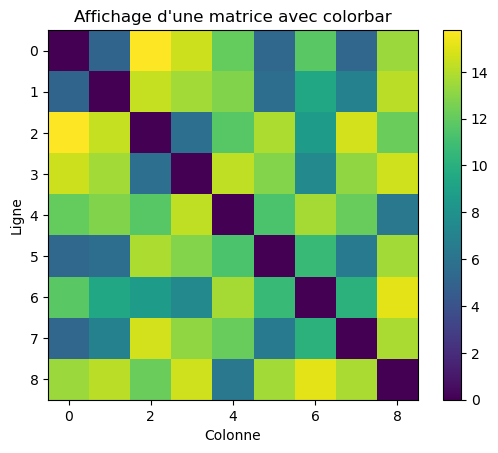

In [15]:
Lxpatern = np.loadtxt("Lxpatern.csv", delimiter=",")
Lnbpatern = np.loadtxt("Lnbpatern.csv", delimiter=",")
def normalize(signal):
    """Normalise un signal en utilisant la méthode du centrage-réduction."""
    mean = np.mean(signal)
    std_dev = np.std(signal)
    return (signal - mean) / std_dev

def euclidean_distance(signal1, signal2):
    """Calcule la distance euclidienne entre deux signaux normalisés de même taille."""
    # Normalisation des signaux avec centrage-réduction
    signal1_norm = normalize(signal1)
    signal2_norm = normalize(signal2)

    # Calcul de la distance euclidienne
    distance = np.sqrt(np.sum((signal1_norm - signal2_norm) ** 2))
    return distance
def etude_patern(Lxpatern):
  n, _ = np.shape(Lxpatern)
  distance_paterns = np.zeros((n,n))
  i = 0

  for patern1 in Lxpatern :
    j = 0
    for patern2 in Lxpatern :
      d = euclidean_distance(patern1, patern2)
      #print("distance", d)
      distance_paterns[i, j] = d
      j += 1
    i += 1
  return distance_paterns
Lxpatern = np.array(Lxpatern)
distance_paterns = etude_patern(Lxpatern)
# Affichage de la matrice avec une colorbar
plt.imshow(distance_paterns, cmap='viridis')  # Choix de la colormap 'viridis' (il y a aussi 'plasma', 'inferno', etc.)
plt.colorbar()  # Ajoute une colorbar à côté de la matrice
plt.title("Affichage d'une matrice avec colorbar")
plt.xlabel("Colonne")
plt.ylabel("Ligne")
plt.show()

La distance DTW (cours 1 [DTW](https://www.laurentoudre.fr/ast.html) de Laurent Oudre) est plus pertinante pour calculer la distance entre signaux car elle est moins sensible au déphasage, contraction/dilatation des motifs. Même si elle l'est tout de même.

Une fois la matrice des distance DTW entre les paterns calculer, nous générons un graphes qui met un lien entre deux paterns si leur distance est inférieur à un seuil donné. Ensuite, nous identifions dans ce graphe tous les ensembles de noeuds où il existe au moins un chemin les reliant pour créer des "famille de motif".

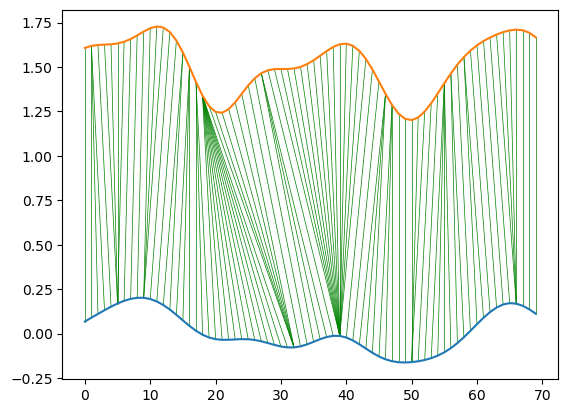

0.5974775896240796
[[0.         0.59747759 1.38173202 0.97690315 0.48867338 0.2713043
  0.73541719 0.34578676 0.70494385]
 [0.59747759 0.         1.71586168 1.33645583 0.86630581 0.64643396
  0.79488457 0.82128667 0.93223592]
 [1.38173202 1.71586168 0.         0.50627009 1.00347379 1.19768046
  0.91480348 1.08988565 0.98401828]
 [0.97690315 1.33645583 0.50627009 0.         0.73477513 0.70944845
  0.47388434 0.82183741 0.57887611]
 [0.48867338 0.86630581 1.00347379 0.73477513 0.         0.34503734
  0.47890575 0.4274364  0.27805952]
 [0.2713043  0.64643396 1.19768046 0.70944845 0.34503734 0.
  0.59851993 0.28540239 0.48078749]
 [0.73541719 0.79488457 0.91480348 0.47388434 0.47890575 0.59851993
  0.         0.76825628 0.53173572]
 [0.34578676 0.82128667 1.08988565 0.82183741 0.4274364  0.28540239
  0.76825628 0.         0.59613318]
 [0.70494385 0.93223592 0.98401828 0.57887611 0.27805952 0.48078749
  0.53173572 0.59613318 0.        ]]


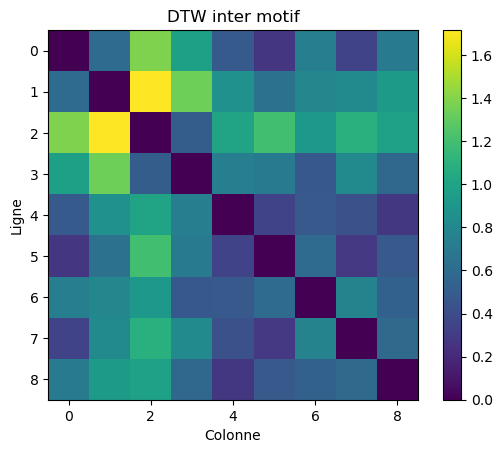

[[4, 5, 7], [], [3], [2, 6], [0, 5, 6, 7, 8], [0, 4, 7, 8], [3, 4, 8], [0, 4, 5], [4, 5, 6]]
[[0, 4, 5, 7, 8, 6, 3, 2], [1]]


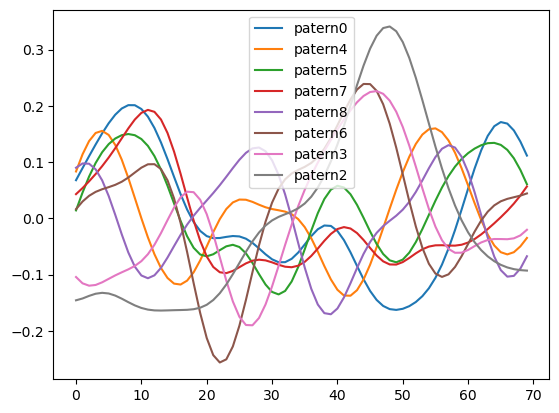

nbpatern_groupe : 1535.0


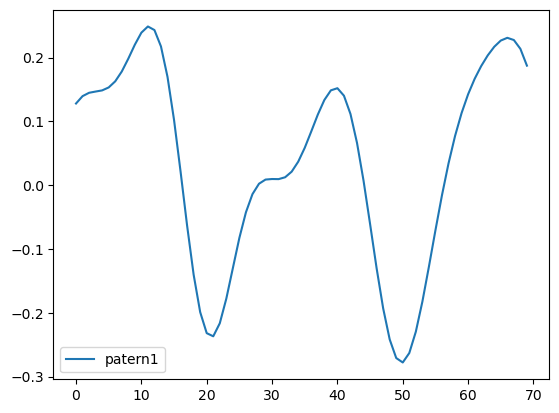

nbpatern_groupe : 480.0


<Figure size 640x480 with 0 Axes>

In [17]:
from scipy.spatial import distance
def dtw(x,y,w=np.Inf):
    Nx=np.size(x)
    Ny=np.size(y)
    x_=np.reshape(x,(Nx,1))
    y_=np.reshape(y,(Ny,1))
    # Computation of the distance matrix
    D= distance.cdist(x_, y_, 'euclidean')**2
    # Computation of the cumulative distance matrix
    C=np.Inf*np.ones((Nx+1,Ny+1))
    C[0,0]=0
    for i in range(1,Nx+1):
        for j in range(int(np.maximum(1,i-w)),int(np.minimum(Ny+1,i+w+1))):
            C[i,j] = D[i-1,j-1] + np.amin([C[i-1,j-1],C[i-1,j],C[i,j-1]])
    # Computation of the path
    path=[[Nx-1,Ny-1]]
    i=Nx-1
    j=Ny-1
    while i>0 and j>0:
        ind=np.argmin([C[i-1,j-1],C[i-1,j],C[i,j-1]])
        if ind==0:
            path = np.insert(path, 0, [i-1, j-1], axis=0)
            i-=1
            j-=1
        elif ind==1:
            path = np.insert(path, 0, [i-1, j], axis=0)
            i-=1
        elif ind==2:
            path=np.insert(path, 0, [i, j-1], axis=0)
            j-=1

    return np.sqrt(C[Nx,Ny]),path

# Plots the two signals and the path
def figure_dtw(x,y,path):
    plt.figure("DTW illustration")
    N=np.size(x)
    M=np.size(y)
    Npath,K=np.shape(path)
    x_max=np.max(x)
    y_min=np.min(y)
    y=y+(x_max-y_min+1)
    for i in range(Npath):
        plt.plot([path[i,0],path[i,1]],[x[path[i,0]],y[path[i,1]]],'-g',linewidth=0.5)
    plt.plot(x)
    plt.plot(y)
    plt.show()

d,path=dtw(Lxpatern[0],Lxpatern[1])
figure_dtw(Lxpatern[0],Lxpatern[1],path)
print(d)


def etude_patern_dtw(Lxpatern):
  n, _ = np.shape(Lxpatern)
  distance_paterns_dtw = np.zeros((n,n))
  i = 0

  for patern1 in Lxpatern :
    j = 0
    for patern2 in Lxpatern :
      d, _ = dtw(patern1, patern2)
      #print("distance", d)
      distance_paterns_dtw[i, j] = d
      j += 1
    i += 1


  print(distance_paterns_dtw)
  return distance_paterns_dtw
Lxpatern = np.array(Lxpatern)
distance_paterns_dtw = etude_patern_dtw(Lxpatern)
# Affichage de la matrice avec une colorbar
plt.imshow(distance_paterns_dtw, cmap='viridis')  # Choix de la colormap 'viridis' (il y a aussi 'plasma', 'inferno', etc.)
plt.colorbar()  # Ajoute une colorbar à côté de la matrice
plt.title("DTW inter motif")
plt.xlabel("Colonne")
plt.ylabel("Ligne")
plt.show()


def lien_patern(Lxpatern, dispat_dtw):
  n, _ = np.shape(Lxpatern)
  Llien =[]
  for i in range(n):
    tempo = []
    for j in range(n):
      if i != j :
        if dispat_dtw[i, j] < 0.54 :
          tempo.append(j)
    Llien.append(tempo)
  return Llien
Llien = lien_patern(Lxpatern, distance_paterns_dtw)
print(Llien)

def find_connected_components(Llien):
    def dfs(node, visited, component):
        visited[node] = True
        component.append(node)
        for neighbor in Llien[node]:
            if not visited[neighbor]:
                dfs(neighbor, visited, component)

    visited = [False] * len(Llien)
    connected_components = []

    for node in range(len(Llien)):
        if not visited[node]:
            component = []
            dfs(node, visited, component)
            connected_components.append(component)

    return connected_components
famille = find_connected_components(Llien)
print(famille)


for i in range(len(famille)):
  nbpatern_groupe = 0
  plt.clf()
  for j in famille[i] :
    nbpatern_groupe += Lnbpatern[j]
    plt.plot(Lxpatern[j], label="patern"+str(j))
  plt.legend()
  plt.show()
  print("nbpatern_groupe :", nbpatern_groupe)
  plt.clf()

Le regourpement des motifs ne fonctionne pas. L'explication est détaillé dans le rapport.

## 4.3 Calcules des features caractérisant nos signaux et PCA


Dans cette partie nous allons calculer un ensemble de features sur notre dataset. Toutes les features calculer sont détaillé dans le rapport.

8


Calcul des features: 100%|████████████████████████████████████████████████████████| 2298/2298 [00:06<00:00, 378.34it/s]


0.011114796791934396
0.0392065500948994
0.011114796791934396
1.4226939893676027
0.047776060022880464
0.24278401651564685
0.07392897210666428
0.2625592344623986
0.038973395030995686
0.0497204072729825
0.043678089122012695
0.04145373926354156
0.006272422271146617
0.00352625707791604
0.004793842112589762
0.0018166908941789743
0.03850624983150823
0.05499020052647857
0.051981185017244684
0.024937147206517737
0.033157262345766804
0.026614816319522002
0.02074048656864674
0.049980135807099896
0.04862545635696126
0.02037401102958407
0.030968122626515455
0.02373026246985449
0.011318246326072628
0.023017457255651276
0.03097055964569405
0.0192299484453485
0.0410930314658728
0.039711776736131875
0.019090574107228246
0.03660816414642545
0.03503694807250531
0.017086096984693662
0.03281843136069053
0.03161356317191122
0.01551568926132247
0.02975166392106922
0.027273774890469168
0.012366418304336815
0.02370722647142245
0.028512572188032558
1.4249969482127331
1.7098468327895529
2.2791537657413175
1.4032

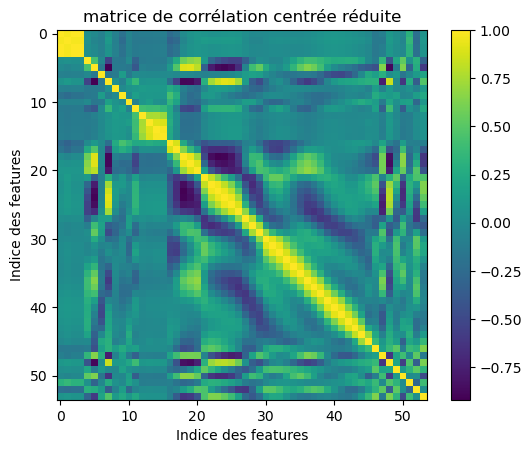

affichage des features: 100%|████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 1104.97it/s]
C:\Users\zehav\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


on affiche les points


affichage cluster2: 100%|█████████████████████████████████████████████████████████| 1448/1448 [00:06<00:00, 216.71it/s]


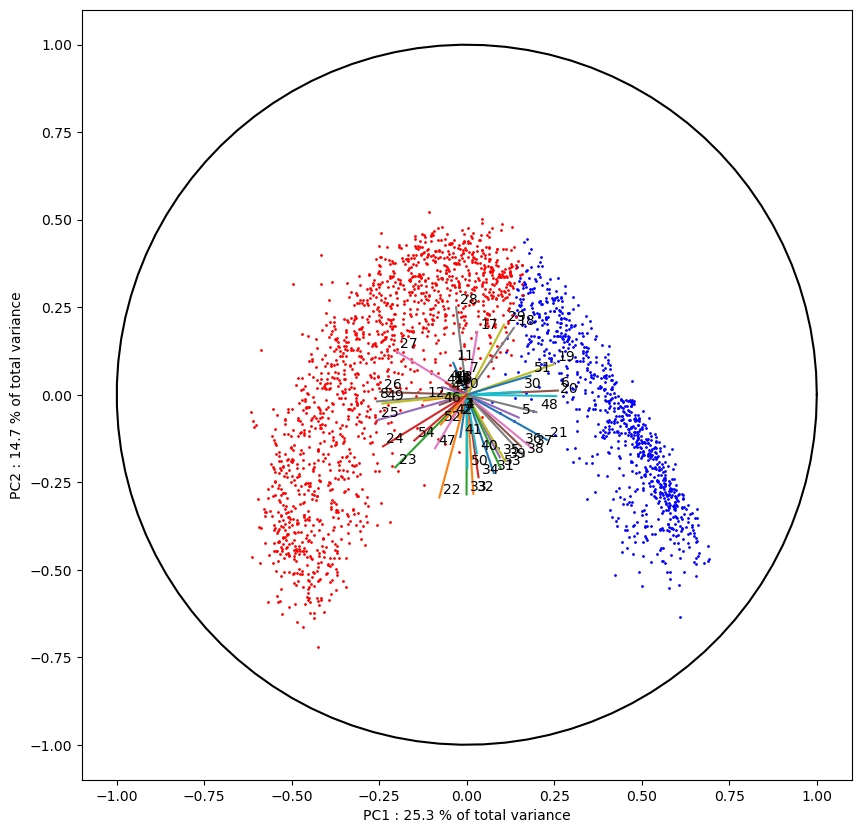

In [18]:
from tqdm import tqdm
from sklearn.cluster import KMeans

def fast_distance_profile_nEUC(x,p):
  c=np.cumsum(np.concatenate(([0],x)))
  c2=np.cumsum(np.concatenate(([0],x))**2)
  N=np.size(x)
  Np=np.size(p)
  p_=(p-np.mean(p))/np.std(p)
  p__=np.zeros((N,))
  p__[0:Np]=np.flip(p_)
  r=np.real(np.fft.ifft(np.multiply(np.fft.fft(x),np.fft.fft(p__))))
  vari=np.sqrt(Np * (c2[Np:-1]-c2[:N-Np]) -  (c[Np:-1]-c[:N-Np])**2)
  d=np.sqrt(np.maximum(2*Np*(1-np.divide(r[Np-1:N-1],vari)),0))
  return d
def k_mean(data_projeter):
  kmeans = KMeans(n_clusters=2,  random_state=0)
  #kmeans = KMeans(n_clusters=2, init=init_centers, n_init=1, random_state=0)
  # Entraînement du modèle sur les données
  kmeans.fit(data_projeter)
  # Prédiction des clusters pour chaque point
  labels = kmeans.predict(data_projeter)
  # Récupération des centres des clusters
  centers = kmeans.cluster_centers_
  # Séparation des points par clusters
  cluster_1 = data_projeter[labels == 0]
  cluster_2 = data_projeter[labels == 1]
  return cluster_1, cluster_2


class AnalysePCA :
  def __init__(self, data):
    self.data = data
    self.xplot = np.linspace(0, 100, len(self.data), endpoint=False)  # De 0 à T (sans inclure T)
    self.data_array = np.array([signal.detrend_filtered_data for signal in self.data])
    self.data_array_transposed = self.data_array.T

  # Function to compute the relative energy in Nb frequency band
  def relative_energy(self, x,Nb,Fs):
    N=np.size(x)
    #Computation of the FFT
    X=np.fft.fft(x)
    f=np.fft.fftfreq(N, d=1/Fs)
    FNyq=6
    E=np.zeros((Nb,))
    for i in range(Nb):
        E[i]=np.sum(np.abs(X[(f>i*FNyq/Nb) & (f<=(i+1)*FNyq/Nb)])**2)
    E=E/np.sum(np.abs(X[(f>=0) & (f<=FNyq/2)])**2)
    return E


  # Biased estimator of the autocorrelation function
  # lags are comprised between -maxLags and +maxLags
  def autocorrelation(self, x,maxLags):
    N=len(x)
    gammax=np.correlate(x,x,'full')/N
    lags=np.arange(-maxLags,maxLags+1)
    gammax=gammax[N-maxLags-1:N+maxLags]

    # Plot the autocorrelation function
    maxLags=50
    return gammax,lags

  def relative_energy_autocorrelation(self,x,Nb,Fs):
    N= np.size(x)
    #Computation of the FFT
    X, lags = self.autocorrelation(x,50)
    FNyq=50
    E_cor =np.zeros((Nb,))
    for i in range(Nb):
        E_cor[i]=np.sum(np.abs(X[(lags>i*FNyq/Nb) & (lags<=(i+1)*FNyq/Nb)])**2)
    E_cor =E_cor/np.sum(np.abs(X[(lags>0) & (lags<=FNyq/2)])**2)
    return E_cor

  def features_paterns(self, x):
    # on télécharge les paterns enregistré sur le drive et leur nombre de répétition dans le signal
    Lxpatern = np.loadtxt("Lxpatern.csv", delimiter=",")
    Lnbpatern = np.loadtxt("Lnbpatern.csv", delimiter=",")

    D_paterns=[]

    for xpatern in Lxpatern[:-1, :]:
      D_paterns.append(np.min(fast_distance_profile_nEUC(x,xpatern)))
    if np.nan in D_paterns :
      print(D_paterns)
    return np.array(D_paterns)


  def compute_features(self):
    X = self.data_array_transposed
    N,M=np.shape(X)
    Nbfeatures = 1
    NbE = 12
    Nbauto = 30
    Nbpaterns = self.features_paterns(X[:,0]).shape[0]
    print(Nbpaterns)
    # On calcul ne nombre total de features
    Nbfeatures += NbE + Nbauto +Nbpaterns

    Y=np.zeros((Nbfeatures,M))

    for i in tqdm(range(M), desc="Calcul des features"):
        indiceold=1
        indice = 1
        Y[0,i]=np.var(X[:,i])

        if NbE != 0:
          E= self.relative_energy(X[:,i],NbE,50)
          indice+=NbE
          Y[indiceold:indice,i]=E
          indiceold=indice
        if Nbauto != 0:
          indice+=Nbauto
          Y[indiceold:indice,i]=self.relative_energy_autocorrelation(X[:, i], Nbauto,50)
          indiceold=indice
        if Nbpaterns != 0:
          indice +=Nbpaterns
          Y[indiceold:indice,i]=self.features_paterns(X[:,i])
    return Y, Nbfeatures

  def compute_features(self):# Fonction calculant la totalité des features
    X = self.data_array_transposed
    N,M=np.shape(X)
    Nbfeatures = 4
    NbE = 12
    Nbauto = 30
    Nbpaterns = self.features_paterns(X[:,0]).shape[0]
    print(Nbpaterns)
    # On calcul ne nombre total de features
    Nbfeatures += NbE + Nbauto +Nbpaterns

    Y=np.zeros((Nbfeatures,M))

    for i in tqdm(range(M), desc="Calcul des features"):
        indiceold=4
        indice = 4
        Y[0,i]=np.var(X[:,i])
        Y[1,i] = np.std(X[:, i])
        Y[2,i] = np.std(X[:, i])**2
        Y[3,i] = np.sum(X[:, i]**2)
        if NbE != 0:# calcul des densité d'energie fréquentielle relative
          E= self.relative_energy(X[:,i],NbE,50)# 12 intervalles de calcule
          indice+=NbE
          Y[indiceold:indice,i]=E
          indiceold=indice
        if Nbauto != 0:# calcul des densité d'energie d'auto-corrélation relative
          indice+=Nbauto
          Y[indiceold:indice,i]=self.relative_energy_autocorrelation(X[:, i], Nbauto,50)
          indiceold=indice
        if Nbpaterns != 0:
          indice +=Nbpaterns
          Y[indiceold:indice,i]=self.features_paterns(X[:,i])
    return Y, Nbfeatures

  def my_pca(self, X):
    D,M=np.shape(X)
    X_=np.zeros((D,M))
    for d in range(D):
        X_[d,:]=(X[d,:]-np.mean(X[d,:]))/np.std(X[d,:])
        print(np.std(X[d,:]))
        if np.std(X[d,:])==0:
          print(X[d,:])
    print(1/M*np.dot(X_, X_.T))
    plt.imshow(1/M*np.dot(X_, X_.T), cmap='viridis')
    plt.colorbar()
    plt.title('matrice de corrélation centrée réduite')
    plt.xlabel('Indice des features')
    plt.ylabel('Indice des features')
    plt.show()
    U,S,Vt=np.linalg.svd(X_)
    var_exp=S**2/(M-1)
    S2=np.zeros((D,M))
    S2[:D,:D]=np.diag(S)
    U = U
    #return U, np.dot(U, np.diag(S)), var_exp
    return U, np.dot(S2,Vt), var_exp

  def plot_correlation_circle(self, U,feature_names,var_exp, S):
    D,D=np.shape(U)
    _,nbdonne = S.shape
    figure, axes = plt.subplots(figsize=(10, 10))
    for d in tqdm(range(D), desc="affichage des features"):
        plt.plot([0,U[d,0]],[0,U[d,1]])
        plt.text(U[d,0]+0.01, U[d,1]+0.01,feature_names[d])
    maxs0 = np.max(np.abs(S[0,:]))
    maxs1 = np.max(np.abs(S[1,:]))
    norme_max = np.sqrt(maxs0**2+maxs1**2)
    S = S/norme_max
    print("on affiche les points")
    cluster_1, cluster_2 = k_mean(S.T[:, :-1])
    for i in tqdm(range(cluster_1.shape[0]), desc = "affichage cluster1"):
      plt.scatter(cluster_1[i,0],cluster_1[i,1], s=1, color='blue', label='Cluster 1')
    for i in tqdm(range(cluster_2.shape[0]), desc = "affichage cluster2"):
      plt.scatter(cluster_2[i,0],cluster_2[i,1], s=1, color='red', label='Cluster 2')
    """for i in tqdm(range(nbdonne), desc = "affichage des données"):
      plt.scatter(S[0,i],S[1,i], s=1)"""
    theta = np.linspace(0, 2*np.pi, 100)
    radius = 1
    a = radius*np.cos(theta)
    b = radius*np.sin(theta)
    axes.set_aspect(1)
    v=np.round(1000*var_exp/np.sum(var_exp))/10
    plt.plot(a,b,'k')
    plt.xlabel("PC1 : "+str(v[0])+" % of total variance")
    plt.ylabel("PC2 : "+str(v[1])+" % of total variance")
    plt.show()

  def analyse_pca(self) :
    Y, nbfeatures = self.compute_features()
    U,S,var_exp=self.my_pca(Y)

    features_names = []
    for i in range(nbfeatures):
      features_names.append("{}".format(i+1))
    self.plot_correlation_circle(U,features_names,var_exp, S)

  def analyse_pca_new(self,Y,  Lfeatures_bien):
    #Y, nbfeatures = self.compute_features()
    Ynew = np.zeros((len(Lfeatures_bien), Y.shape[1]))
    for i in range(len(Lfeatures_bien)):
      Ynew[i,:] = Y[Lfeatures_bien[i],:]
    U,S,var_exp=self.my_pca(Ynew)
    features_names = []
    for i in range(len(Lfeatures_bien)):
      features_names.append("{}".format(Lfeatures_bien[i]+1))
    self.plot_correlation_circle(U,features_names,var_exp, S)


AnalyseData_class = AnalysePCA(Datas_class)
#Y = AnalyseData_class.compute_features()
AnalyseData_class.analyse_pca()


Nous observons que la PCA met en évidence deux clusters dans notre dataset que nous séparons à l'aide de l'algorithme K-means. L'analyse du PCA est détaillé dans le rapport.

La suite du code affichant les features pertinantes est dans le notebook du rapport.